# 👨‍💻 ANÁLISE 👨‍💻

Nesta seção serão apresentados as principais análises e conclusões do estudo. O roteiro de análise é o seguinte:

- _Contextualização e Números Gerais_ 
- _Distribuição da Ocorrência de Leads_
- _Análise de Outliers e Segmentações_
- _Análise de Outras Variáveis_
- _Conclusão_

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import customFunctions as cF
import numpy as np
import pandas as pd
from scipy.stats import variation
from sklearn.cluster import KMeans

In [65]:
%matplotlib inline

# DEFINIÇÃO 📚

Com o intuito de isolar o impacto da relevância dos anúncios e particularidades de cada segmentação, serão realizadas duas medidas para interpretação do desempenho:</br>
> **CONVERSÃO EM LEAD** = Anúncios com leads / total de anúncios</br>
> **LEAD POR ANÚNCIO** =  Soma de leads/ quantidade de anúncios

In [66]:
# recupera o dataframe do Notebook anterior
%store -r merged

In [67]:
# Contingência: Carrega o mesmo dataframe caso necessário 
# merged = pd.read_csv('./merged.csv')

# CONTEXTO 📽️
Antes de direcionar a análise para a performance de **_Leads_** é importante ter uma visão do todo. Para isso, serão respondidas as perguntas sugeridas:

 1. _Quantos anúncios ativos no site exibem endereço completo?_
 2. _Quantos anúncios ativos no site receberam leads?_
 3. _O desempenho é uniforme para todos os segmentos de anúncios?_

In [68]:
# Cria função personalizada para contabilizar apenas anúncios com 1 lead ou mais
at_least_one = lambda x:  sum(x>0)
at_least_one.__name__ = 'at_least_one'

#Cria classe agrupada para agregação e cálculos segmentados
overview = merged.groupby(['portal', 'listing_type','address_info'])
overview = overview.agg({'listing_id':'count', 'leads': [at_least_one,'sum']})
overview.columns = [f'{tupla[0]}_{tupla[1]}' if tupla[1]!="" else tupla[0] for tupla in overview.columns]

In [69]:
# Manipula dataframe para resposta das 2 primeiras perguntas
um_dois = overview.reset_index().drop(columns=['portal','listing_type'])
um_dois = um_dois.groupby('address_info').sum().reset_index().sort_values('listing_id_count', ascending=False)
um_dois = um_dois.append(um_dois.sum(numeric_only=True), ignore_index=True)
um_dois.iloc[3,0] = "TOTAL"
# Cria colunas com as medidas de desempenho
um_dois['to_lead_conversion'] = um_dois['leads_at_least_one'] / um_dois['listing_id_count']
um_dois['leads_p_listing'] = um_dois['leads_sum'] / um_dois['leads_at_least_one']

um_dois

,address_info,listing_id_count,leads_at_least_one,leads_sum,to_lead_conversion,leads_p_listing
0,RUA,104255.0,10259.0,25356.0,0.098403,2.471586
1,BAIRRO,85871.0,5361.0,13851.0,0.062431,2.583660
2,ENDEREÇO COMPLETO,21996.0,3829.0,12559.0,0.174077,3.279969
3,TOTAL,212122.0,19449.0,51766.0,0.091688,2.661628


 **1. Quantos anúncios ativos no site exibem endereço completo?** <br>
 **2. Quantos anúncios ativos no site receberam leads?**

> 1 - Anúncios que exibem endereço são a minoria: </br>
_21.996 ~ 10% da base_ </br>
 2 - A quantidade anúncios ativos que receberam pelo menos um lead é: </br>
_19.449 ~ 9% da base_ </br>
Inicialmente e de forma agregada, anúncios com endereço completo tem um melhor desempenho tanto na taxa de anúncios com pelo menos um lead quanto na média de leads por anúncio.</br>
Porém, uma análise mais detalhada será feita para se certificar que estes números são comparáveis


In [70]:
tres = merged.query('leads>0')
tres = tres.groupby('listing_type').agg({'listing_id':'count','leads':'mean'}).sort_values(by='listing_id', ascending=False)
tres.columns = ['listing_count', 'leads/listing']

tres

,listing_count,leads/listing
listing_type,,
VENDA,14539,2.301809
ALUGUEL,4756,3.645290
NÃO IDENTIFICADO,154,6.253247


 **3. O desempenho é uniforme para todos os segmentos de anúncios?**

>Cada segmento tem um volume e performance diferente. </br>
A performance é maior quanto menor o volume, o que poderia ser explicado pela maior sensibilidade ao efeito de outilers em categorias com volumes menores.</br>
Ainda, os anúncios que não tiveram seu segmento identificados possuem um preço/m2 que não se encaixa em nenhuma das outras categorias </br>
Dessa forma, sendo o preço muito baixo, este mesmo pode ser o motivo da média de lead/anúncio ser muito maior que nas outras classificações.</br>
Como são apenas 154 registros não identificados, estes serão excluídos da análise para simplificação.

In [71]:
# Exclui registros sem segmento identificado
merged = merged.query('listing_type != "NÃO IDENTIFICADO"').copy()

# UMA VISÃO DO TODO 🗺️
Para complementar a contextualização dos dados do negócio, é válida a visualização da representatividade das principais métricas e segmentações a serem analisadas.</BR>
Como observado anteriormente, os anúncios de  **_ALUGUEL_** e de **_VENDA_** têm desempenhos diferentes. Por isso, os dados abaixo estão divididos em dois dataframes.</BR>
Além disso, em cada um deles há a segmentação por **_PORTAL_** e **_EXIBIÇÃO DO ENDEREÇO_** </BR>
As colunas numéricas seguem ordem similar à de um <u>**_funil de vendas_**</u>:
1. Total de Anúncios - **_(%  do Total)_**
2. Taxa de Conversão para Lead
3. Total de Anúncios com Lead - **_(%  do Total)_**
4. Taxa de Lead por Anúncio
5. Total de Leads - **_(%  do Total)_**

In [72]:
at_least_one = lambda x:  sum(x>0)
at_least_one.__name__ = 'at_least_one'


#merged.loc[(merged['address_info'] == "BAIRRO") |(merged['address_info'] == "RUA"),'address_info'] ="INCOMPLETO"

for segmento in ['VENDA', 'ALUGUEL']:

    overview = merged.query('listing_type == @segmento').groupby(['portal', 'listing_type','address_info'])
    overview = overview.agg({'listing_id':'count', 'leads': [at_least_one,'sum']})
    overview.columns = [f'{tupla[0]}_{tupla[1]}' if tupla[1]!="" else tupla[0] for tupla in overview.columns]

    overview['to_lead_conversion'] = overview['leads_at_least_one']/overview['listing_id_count']
    overview['leads_p_listing'] = overview['leads_sum']/overview['leads_at_least_one']

    col_prct= ['listing_id_count', 'leads_at_least_one','leads_sum']
    overview_prct = overview.copy()
    overview_prct[col_prct] = overview[col_prct].apply(lambda x: (x/sum(x)))
    
    overview_prct.reset_index(inplace=True)
    overview_prct.sort_values(by=('listing_id_count'),ascending=False, inplace=True)
    overview_prct.set_index(pd.Index(range(1,len(overview_prct)+1)), inplace=True)
    #overview_prct['leads_prct_accum'] = overview_prct['leads_sum'].cumsum()
    
    overview_prct = overview_prct.reindex(columns = [
        'listing_type','portal', 'address_info','listing_id_count', 'to_lead_conversion',
        'leads_at_least_one', 'leads_p_listing', 'leads_sum'
    ])

    display(overview_prct.style.background_gradient(cmap='PuBu'))

,listing_type,portal,address_info,listing_id_count,to_lead_conversion,leads_at_least_one,leads_p_listing,leads_sum
1,VENDA,VIVAREAL,BAIRRO,0.390450,0.046016,0.243070,2.021222,0.213441
2,VENDA,VIVAREAL,RUA,0.333881,0.056949,0.257239,2.100802,0.234776
3,VENDA,ZAP,RUA,0.152723,0.125533,0.259371,2.285601,0.257545
4,VENDA,VIVAREAL,ENDEREÇO COMPLETO,0.103281,0.158750,0.221817,2.912248,0.280643
5,VENDA,ZAP,BAIRRO,0.019665,0.069545,0.018502,1.691450,0.013596


,listing_type,portal,address_info,listing_id_count,to_lead_conversion,leads_at_least_one,leads_p_listing,leads_sum
1,ALUGUEL,VIVAREAL,RUA,0.336592,0.298598,0.309083,3.504082,0.297110
2,ALUGUEL,VIVAREAL,BAIRRO,0.304048,0.300427,0.280908,4.063623,0.313145
3,ALUGUEL,ZAP,RUA,0.220703,0.370198,0.251262,2.865272,0.197497
4,ALUGUEL,VIVAREAL,ENDEREÇO COMPLETO,0.106044,0.366215,0.119428,4.864437,0.159370
5,ALUGUEL,ZAP,BAIRRO,0.032613,0.392034,0.039319,3.048128,0.032878


### TAKEAWAYS
> Apesar do maior volume, os anúncios com informação apenas de **RUA** e **BAIRRO** possuem uma **_conversão anúncio>lead_** menor, assim como a **_taxa de lead/anúncio_**.</br>
Esta relação pode ser visualizada pela alternância de cores entre as colunas de <u>_volume e conversão_</u> que se seguem.</br>
No caso dos anúncios de **VENDA**, este comportamento faz com que os anúncios com **ENDEREÇO COMPLETO** sejam responsáveis pela maior parte dos leads criados.</nr>

**Ponto de Atenção:** O portal ZAP não possui nenhum registro com a exibição do endereço completo.

# A PERGUNTA 🎯
**_Aúncios com endereço incompleto possuem um melhor desempenho?_**
> Sabendo do contexto do negócio, é possível seguir para uma análise mais detalhada e focada.</br>
Apesar de já calculadas algumas medidas importantes, para realizar conclusões é preciso entender como estes resultados são formados.</br>

_Aqui, o primeiro passo será entender como é distribuiída a ocorrência de leads por anuncio._

In [73]:
# Seleciona apenas anúncios que possuem ao menos 1 lead
has_lead = merged.query('leads.notnull()').copy()

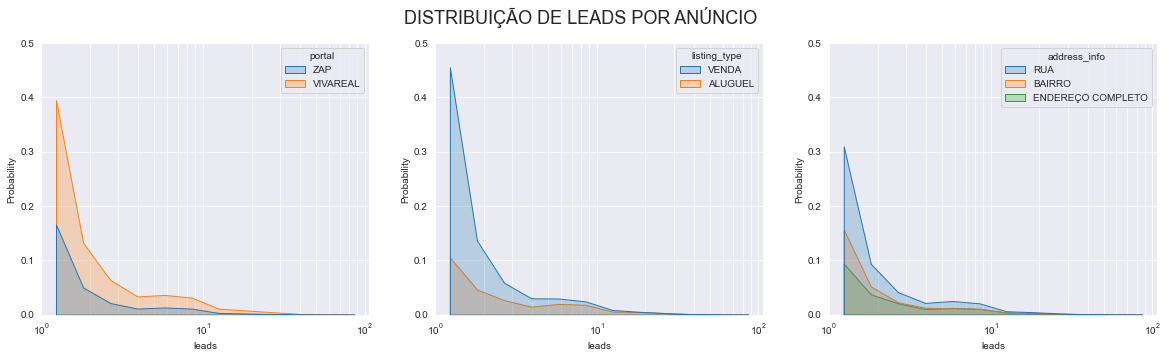

In [74]:
# Gráfico de ocorrência de quantidade de leads/anúncio
sns.set_style('darkgrid')
fig, axs = plt.subplots(1,3, figsize = (20, 5))
fig.suptitle('DISTRIBUIÇÃO DE LEADS POR ANÚNCIO', fontsize=18)

viz_seg = ['portal','listing_type', 'address_info']

for seg in viz_seg:  
    sns.histplot(data = has_lead, x='leads', hue= f'{seg}', bins =12, log_scale=True, element='poly', stat='probability', ax=axs[viz_seg.index(seg)]) ;
    axs[viz_seg.index(seg)].grid(True, 'minor')
    axs[viz_seg.index(seg)].set_ylim(0,0.5)

### TAKEAWAYS
> O gráfico mostra a distribuição da ocorrência de **leads/anúncio** em 1 mês. Quanto maior o número de leads menor a probabilidade de ocorrência, similarmente ao que ocorre em uma distribuição de _Poisson_.</br>
A maioria dos anúncios que receberam algum lead, têm aproximadamente entre **_1 e 3 leads no mês de maio_**. </br>
É clara a presença de _outliers_ que podem induzir a uma conclusão errada ao comparar agregações de categorias.</br>
>As segmentações de maior ocorrência têm uma **_dispersão maior_** em relação as de menor ocorrência.</br> 
Ou seja, as segmentações de menor volume são mais **_homogêneas_**. Portanto, a probabilidade de um anúncio receber muitos leads não é tão distante da probabilidade de um anúncio receber um único lead quanto é nas segmentações de maior volume. </BR>

_**Este comportamento reforça o fato da média de lead/anúncio calculada na seção anterior ser maior para "ENDEREÇO COMPLETO" do que para os outras segmentações.</br>
Uma vez que estes anúncios tem proporcionalmente mais anúncios com muitos leads.**_
 

Para averiguar este comportamento numericamente, será calculada o coeficiente de variação de cada umas delas:

In [75]:
# Agrupa dataframe e manipula para visualização
prob_freq = has_lead.copy()
prob_freq = prob_freq.groupby(['leads', 'address_info']).agg({'leads':'count'})
prob_freq['probability'] = prob_freq['leads']/ prob_freq['leads'].sum()
prob_freq
prob_freq.drop(columns='leads', inplace=True)
prob_freq.reset_index(level=1, inplace=True)
prob_freq = prob_freq.pivot(columns='address_info')
prob_freq.columns = [f'{tupla[1]}' for tupla in prob_freq.columns]
prob_freq.fillna(0, inplace=True)
index=prob_freq.columns
pd.DataFrame(index = list(index),
             columns=['VARIAÇÃO DE PROBABILIDADE'],
             data=[variation(prob_freq[address]) for address in prob_freq.columns]).\
sort_values('VARIAÇÃO DE PROBABILIDADE')

,VARIAÇÃO DE PROBABILIDADE
ENDEREÇO COMPLETO,4.071448
BAIRRO,4.670619
RUA,4.787782


**_Como esperado, anúncios mais específicos variam menos em relação à média._**</br>
O próximo passo será entender como se dá esta variação e se há algum tipo de anúncio específico que concentre a geração de leads.

# OUTLIERS 🐋

Os outliers são os anúncios com **_ótimo desempenho_**, por isso estes não serão exluídos, mas destacados para uma análise separada.</br>
Assim é possível determinar um comportamento padrão para cada classificação de anúncio, inclusive os outliers.</br>
É possível que a performance do anúncio também esteja correlacionada ao seu **_custo benefício_**.</br>
Por isso, foram cruzados os dados de **_preço/m2_** e quantidade de **_leads_** para visualização.

**_Os outliers serão considerados aqueles anúncios que tiverem quantidade de leads maior ou igual a:_** $Q3 + 1.5*IQ$


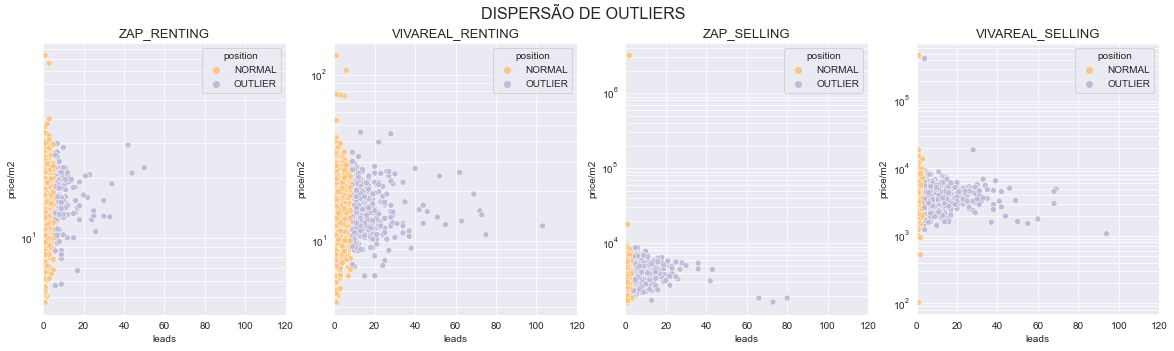

In [76]:
# Cria uma coluna para armazenar classificação de outlier
has_lead['position'] = "NORMAL"

# Cria filtros para análise segmentada de outliers
rent_zap = has_lead.query('listing_type == "ALUGUEL" & portal == "ZAP"').copy()
sell_zap = has_lead.query('listing_type == "VENDA" & portal == "ZAP"').copy()
rent_vr = has_lead.query('listing_type == "ALUGUEL" & portal == "VIVAREAL"').copy()
sell_vr = has_lead.query('listing_type == "VENDA" & portal == "VIVAREAL"').copy()

# Cria dicionário para armazenar os dataframes filtrados para o cálculo 
dfs = {'ZAP_RENTING': rent_zap, "VIVAREAL_RENTING": rent_vr, 
       'ZAP_SELLING': sell_zap, 'VIVAREAL_SELLING': sell_vr
      }

# Configura plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(1,4, figsize = (20, 5))
fig.suptitle('DISPERSÃO DE OUTLIERS', fontsize=16)

# Calcula outliers e plota os dados
for name in dfs.keys():
    df = dfs[name]
    indice = list(dfs.keys()).index(name)
    out= cF.HomeMadeStats(df['leads']).outliers()
    df.loc[ (df['leads'] <= out['min']) | (df['leads'] >= out['max']), 'position'] = "OUTLIER"
    sns.scatterplot(x='leads', y='price/m2', palette ='PuOr', hue='position',
                    hue_order = ['NORMAL', 'OUTLIER'], data = df, ax=axs[indice])
    axs[indice].set_title(f'{name}', fontsize=13)
    axs[indice].set_yscale('log')
    axs[indice].grid(True, 'minor')
    axs[indice].set_xlim(0,120);

### TAKEAWAYS 
> Os gráficos sugerem que os **_outliers_** têm **_impacto_** considerável no **_performance_** de cada segmentação.</br>
Há uma característica comum em todos eles, os outliers estão em sua maioria **_concentrados em valores de preço/m2 medianos_**. </br>
Este comportamento indica que exista uma **_faixa de preço com melhor desempenho_**.</br>
Mas também que algum **_outro fator_** diferencia os anúncios outliers dos classificados aqui como "normais" que ocupam esta mesma faixa.

# SEGMENTAÇÕES 🗃️
Após a identificação e classificação dos outliers, é possível analisar a distribuição da ocorrência de leads de forma segmentada.</br>
Com isso, será possível comparar a amplitude e concentração de cada segmento.

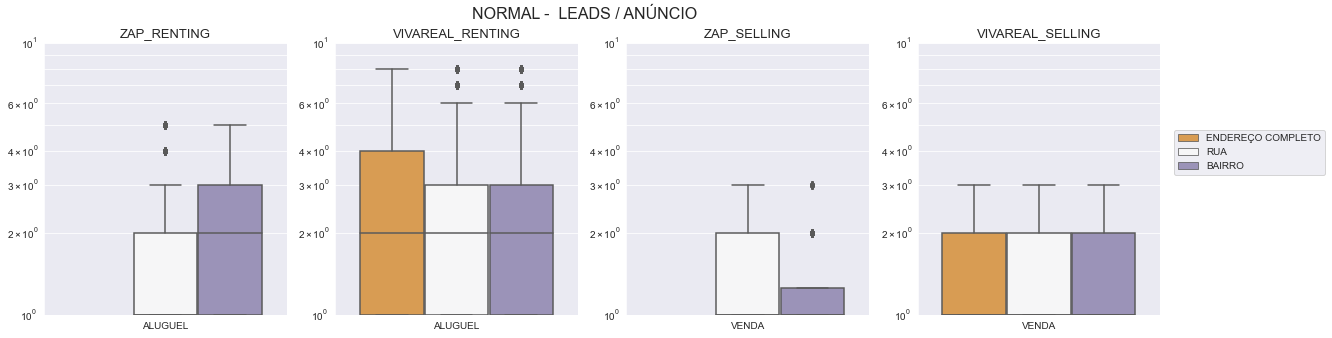

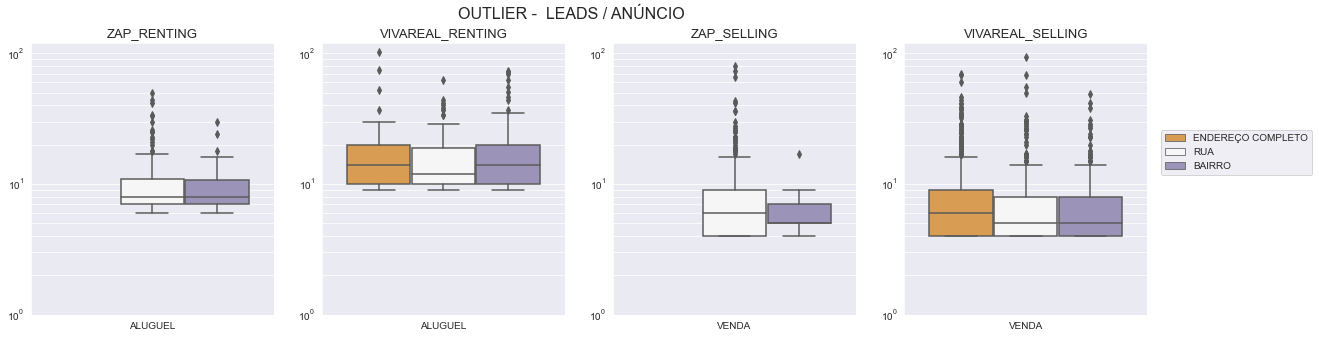

In [77]:
# Armazena classificações a serem filtradas nos dataframes
position = ['NORMAL', 'OUTLIER']

# Plota boxplot para outliers e não outliers, segmentado por tipo de anúncio e informação de endereço
for p in position:
    fig, axs = plt.subplots(1,4, figsize=(20 ,5))
    fig.suptitle(f'{p} -  LEADS / ANÚNCIO', fontsize=16)
    for name in dfs.keys():
        df = dfs[name]
        indice = list(dfs.keys()).index(name)
        sns.boxplot(x="listing_type", y="leads", hue="address_info", palette ='PuOr',
                      hue_order=["ENDEREÇO COMPLETO", "RUA", "BAIRRO"],
                      data = df.query('position == @p'), ax=axs[indice])
        axs[indice].set_title(f'{name}', fontsize=13)
        axs[indice].set_yscale('log')
        axs[indice].set_xlabel(None)
        axs[indice].set_ylabel(None)
        axs[indice].grid(True, 'minor')
        axs[indice].get_legend().remove()
        if p =="NORMAL":
            axs[indice].set_ylim(1,10)
        else:
            axs[indice].set_ylim(1,120)
    axs[indice].legend(bbox_to_anchor=(1.7, 0.7));

### TAKEAWAYS

#### VIVAREAL
> Os gráficos mostram que anúncios com o **ENDEREÇO COMPLETO** têm distribuição de desempenho muito parecidas com as de anúncios com menos infomações.</BR>
Contudo, os anúncios que exibem todo seu endereço **_alcaçam quantidades majoritariamente maiores de leads_**, exceto no segmento de **_VENDA_** com desempenho **_NORMAL_**</BR>

#### ZAP
> Como observado anteriormente, não há registros com a exibição total do endereço no portal.</br>
Ainda assim, desconsiderando-se os outliers, nota-se que apenas para anúncios de **ALUGUEL**, endereços menos específicos **_alcançam maiores quantidades de leads_**.</br>

#### ZAP x VIVAREAL
>Apesar das particularidades de cada portal, pode-se utilizar as medidas do **ZAP** como **_benchmark_** para comparação com os resultados do **VIVAREAL**.</br>
Sendo assim, em todos os casos evidencia-se que anúncios com **_ENDEREÇO COMPLETO_** do **VIVAREAL** alcançam **_resultados maiores_** que qualquer anúncio do **ZAP**</br>
A diferença de **_volume de anúncios_** entre os portais e possivelmente do **_tráfego_**, poderia ser uma explicação de um menor potencial de geração de **_leads_**. </BR>

In [78]:
# Armazena a classificação de outliers realizada
to_update = pd.concat([dfs[name] for name in dfs.keys()])
has_lead = pd.concat([has_lead, to_update]).drop_duplicates(subset='listing_id', keep='last')

# SO WHAT? 🤷
As observações realizadas mostram que os anúncios com e sem endereço completo possuem **_comportamentos muito parecidos_**.</br>
Porém fatores como o **_volume e a ocorrência de outliers_**, que não necessariamente estão relacionados à exibição do endereço, impactam o **_desempenho agregado_** destas segmentações.
Para compreender melhor este impacto, seguem abaixo 2 visualizações que resumem o desempenho de cada segmentação no mês de _Maio/2019_:
1. **_Gráfico das Médias de Lead/Anúncio_**
2. **_Quadro Resumo_**

In [79]:
#Cria dataframe agregado
summary= has_lead.groupby(['listing_type','address_info','position']).agg({'leads':'mean'}).reset_index()

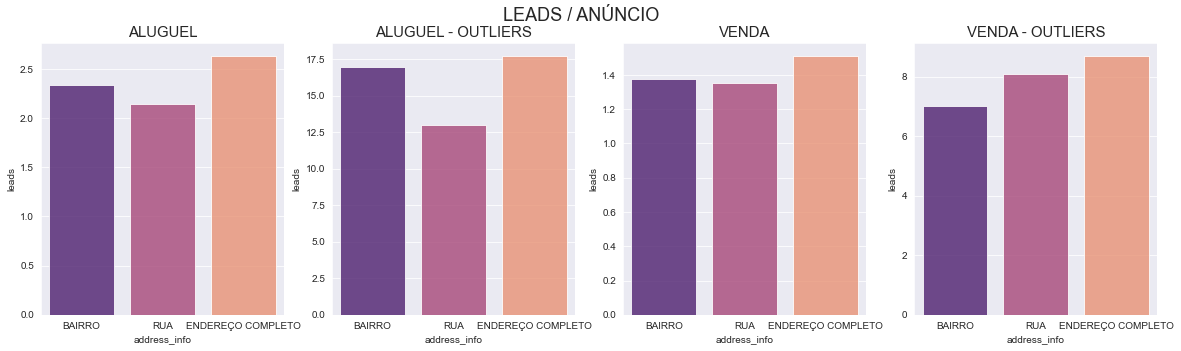

In [80]:
# Plota dados agregados de cada segmentação
fig, axs =  plt.subplots(1,4, figsize= (20,5))

fig.suptitle('LEADS / ANÚNCIO', fontsize=18)

sns.barplot(x='address_info', y='leads', data = summary.query('position != "OUTLIER" & listing_type=="ALUGUEL"'),
            order=["BAIRRO","RUA","ENDEREÇO COMPLETO"], palette ='magma', ax=axs[0], ci=None, alpha=0.8)
axs[0].set_title("ALUGUEL", fontsize=15)

sns.barplot(x='address_info', y='leads', data = summary.query('position == "OUTLIER" & listing_type=="ALUGUEL"'),
            order=["BAIRRO","RUA","ENDEREÇO COMPLETO"],  palette ='magma', ax=axs[1], ci=None,alpha=0.8)
axs[1].set_title("ALUGUEL - OUTLIERS", fontsize=15)

sns.barplot(x='address_info', y='leads', data = summary.query('position != "OUTLIER" & listing_type=="VENDA"'),
            order=["BAIRRO","RUA","ENDEREÇO COMPLETO"],  palette ='magma', ax=axs[2], ci=None, alpha=0.8)
axs[2].set_title("VENDA", fontsize=15)

sns.barplot(x='address_info', y='leads', data = summary.query('position == "OUTLIER" & listing_type=="VENDA"'),
            order=["BAIRRO","RUA","ENDEREÇO COMPLETO"],  palette ='magma', ax=axs[3], ci=None, alpha=0.8)
axs[3].set_title("VENDA - OUTLIERS", fontsize=15);

### TAKEAWAYS
> O gráfico é referente aos valores agregados dos **_dois portais_**.</br>
> Tanto para os casos de **_outliers_** quanto para os casos de desempenho **_normal_**, os anúncios com **_endereço completo_** têm desempenho **_ligeiramente melhor_** do que os outros

In [81]:
# Consolida e manipula dataframes para visualização
vr =  has_lead[has_lead['portal']!='ZAP'].copy()
w_zap = has_lead.copy()
cons = has_lead.copy()

dfs ={'w_zap': [w_zap], 'vr': [vr], 'cons': [cons] }

for name in dfs.keys():
    if str(name) != 'cons':
        dfs[name][0].loc[dfs[name][0]['address_info'] != 'ENDEREÇO COMPLETO', 'address_info'] ="ENDEREÇO INCOMPLETO"
        dfs[name][0] = dfs[name][0].groupby(['position','listing_type','address_info']).agg({'leads':'mean'}).reset_index()
        norm = dfs[name][0].query('position == "NORMAL"')
        outl = dfs[name][0].query('position == "OUTLIER"')
        dfs[name] = [norm,outl]    
    else:
        dfs['cons'][0].loc[dfs['cons'][0]['address_info'] != 'ENDEREÇO COMPLETO', 'address_info'] ="ENDEREÇO INCOMPLETO"
        dfs['cons'][0] = dfs['cons'][0].groupby(['listing_type','address_info']).agg({'leads':'mean'}).reset_index()            
            
norm = pd.merge(dfs['vr'][0], dfs['w_zap'][0], how="inner", on=["position", "listing_type","address_info"])
norm.rename(columns={'leads_x':'VIVAREAL', 'leads_y':'VIVAREAL + ZAP'}, inplace=True) 
norm =norm.pivot(index=['position', 'listing_type'], values=['VIVAREAL', 'VIVAREAL + ZAP'], columns='address_info')
norm = norm.drop(columns=[('VIVAREAL + ZAP',   'ENDEREÇO COMPLETO')])

outl = pd.merge(dfs['vr'][1], dfs['w_zap'][1], how="inner", on=["position", "listing_type","address_info"])
outl.rename(columns={'leads_x':'VIVAREAL', 'leads_y':'VIVAREAL + ZAP'}, inplace=True) 
outl =outl.pivot(index=['position', 'listing_type'], values=['VIVAREAL', 'VIVAREAL + ZAP'], columns='address_info')
outl = outl.drop(columns=[('VIVAREAL + ZAP',   'ENDEREÇO COMPLETO')])

cons = dfs['cons'][0]
cons.rename(columns={'leads':'LEADS/ANÚNCIO'}, inplace=True)
cons =cons.pivot(index=['listing_type'], values=['LEADS/ANÚNCIO'], columns='address_info')

display("MÉDIA DE LEADS/ANÚNCIOS",norm.style.background_gradient(cmap='PuBu', axis=1)
        ,"MÉDIA DE LEADS/ANÚNCIOS", outl.style.background_gradient(cmap='PuBu', axis=1)
        ,"MÉDIA DE LEADS/ANÚNCIOS", cons.style.background_gradient(cmap='PuBu',axis=1)
       )

'MÉDIA DE LEADS/ANÚNCIOS'

'MÉDIA DE LEADS/ANÚNCIOS'

'MÉDIA DE LEADS/ANÚNCIOS'

### TAKEAWAYS
> Visto que os portais têm certa especificidade, é importante também analisar os resultados separadamente.</br>
Como o **_ZAP_** não apresenta registros de endereço completo, comparou-se o desempenho de **_VIVAREAL + ZAP_** e apenas **_VIVAREAL_**</br>
Esta visão deixa claro que no segmento de **_ALUGUEL_**, em que o **_ZAP_** possui **_maior representatividade de anúncios, seu impacto é negativo_** para o agreado de anúncios sem endereço completo.</br>
Curiosamente, neste segmento o portal possui uma alta **_taxa de anúncios com lead (~38%)_**, porém sua **_média de leads/anúncio_** é menor que a do **_VIVAREAL_**. </br>
O que reforça a hipótese de que o desempenho do portal **_ZAP_** é impactado por um provável **_tráfego menor_**.

# OUTRAS VARIÁVEIS 📊
**_Por quê alguns anúncios tem um desempenho muito melhor do que a média?_**</br>
**_Quais outros fatores podem influenciar este comportamento?_**</br>
Para entender um pouco melhor estas relações, algumas outras variáveis serão analisadas.</br>

## DATA DE CRIAÇÃO ⌛
A data de criação é um atributo que pode servir como **_parâmetro de relevância do anúncio_**. Um Anúncio muito antigo podem, por exemplo, não ser tão interessante para o **_público atual_**, não estar mais **_disponível_** ou até ter sido postado quando alguma **_feature do portal_** ainda não estava em produção. </br>
Para entender se há **_relação_** com a quantidade de **_leads gerados_**, foi observado a **_distribuição de anúncio entre as diferentes datas_**

In [82]:
#Converte o campo em data e formata como string desejada
date = pd.to_datetime(merged['created_date']).dt.strftime("%Y-%m")

# Agrega os dados por MÊS/ANO
creation_date = merged.groupby(by = date)
vol = creation_date.agg({
    'listing_id' :'count',
    'leads':['sum','mean'],
    'advertiser_id':'nunique'
})

# Cria nomes e renomeia as colunas 
col_names = [f'{tuplas[0]}_{tuplas[1]}' for tuplas in vol.columns]
vol.columns = col_names

# Calcula taxa de Leads/anúncio publicado/ mês
vol['lead_listing_all'] = vol['leads_sum']/vol['listing_id_count']

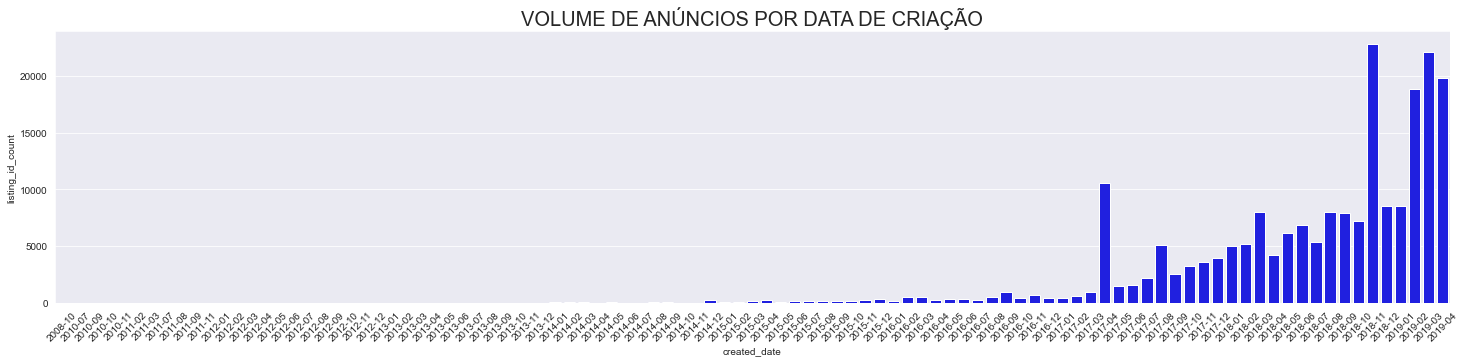

In [83]:
#Plota quantidade de anúncios criados/mês
fig, axs =  plt.subplots(1,1, figsize= (25,5))

plt.xticks(rotation=45)

plt.title('VOLUME DE ANÚNCIOS POR DATA DE CRIAÇÃO', fontsize= 20)

sns.barplot(x=vol.index, y='listing_id_count',  label = 'listings', color ='blue',data=vol, ax=axs);

### TAKEAWAYS
> O gráfico mostra que a maior parte dos anúncios ativos foram criados a partir de **_Março/2017_**.</br>
Nota-se que existem  **_picos de criação_** de anúncio, o que poderia indicar a criação de anúncios em massa por alguns poucos anunciantes, possivelmente com **_características semelhates_** e até referetentes ao **_mesmo imóvel ou loteamento_**.</br>
Para simplificação da visualização foi realizado um **_recorte_** a partir do período em que a **_quantidades de anúncios publicados por mês é mais representativa_**

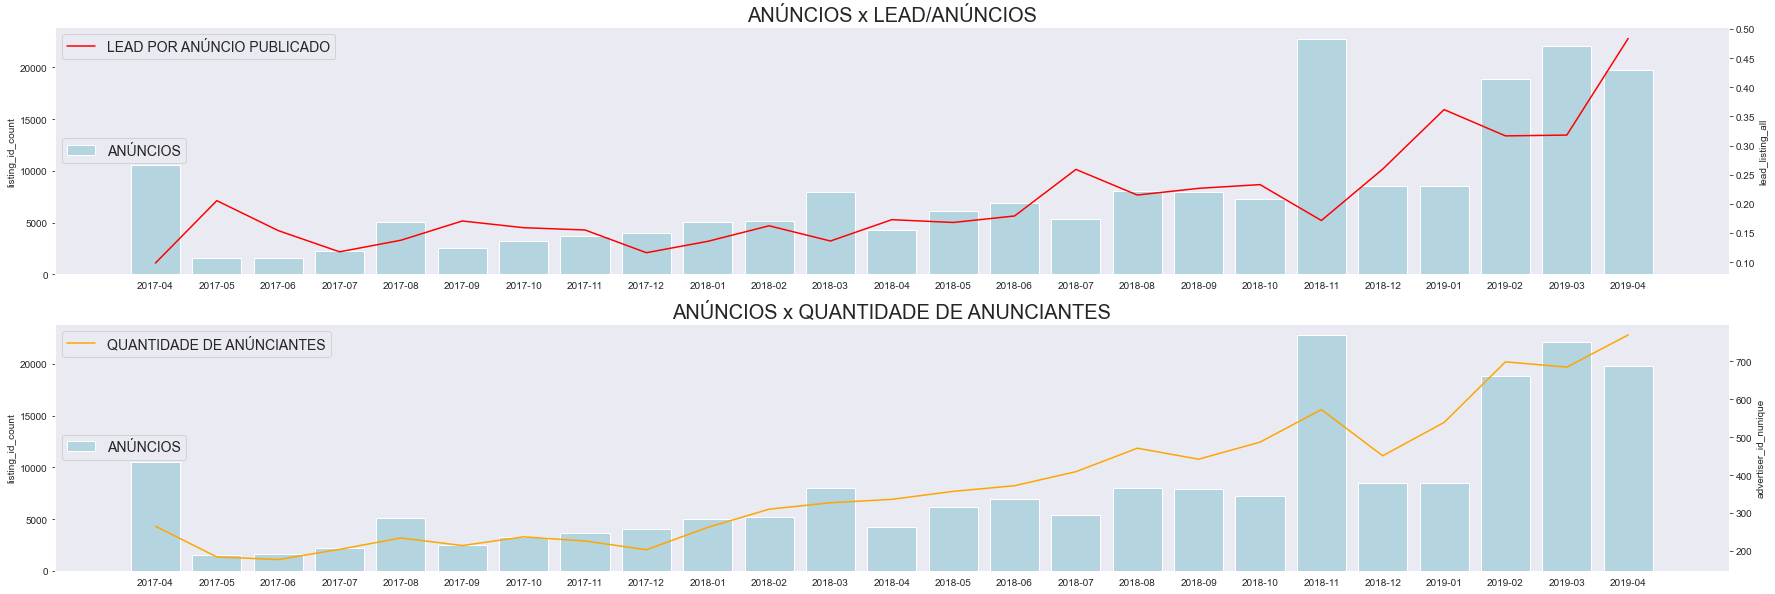

In [84]:
vol = vol.loc['2017-03-01':]

fig, axs =  plt.subplots(2,1, figsize= (30,10))

ax1 = axs[0].twinx()
ax2 = axs[1].twinx()

sns.barplot(x=vol.index, y='listing_id_count', label = 'ANÚNCIOS', color ='lightblue',data=vol, ax=axs[0])
sns.lineplot(x=vol.index, y='lead_listing_all', label='LEAD POR ANÚNCIO PUBLICADO', color = 'red', data=vol, ax=ax1)\
.set_title("ANÚNCIOS x LEAD/ANÚNCIOS", fontsize=20)

sns.barplot(x=vol.index, y='listing_id_count', label = 'ANÚNCIOS', color ='lightblue',data=vol, ax=axs[1])
sns.lineplot(x=vol.index, y='advertiser_id_nunique', label='QUANTIDADE DE ANÚNCIANTES', color = 'orange', data=vol, ax=ax2)\
.set_title("ANÚNCIOS x QUANTIDADE DE ANUNCIANTES", fontsize=20)

axs[0].grid(False)
ax1.grid(False)
axs[1].grid(False)
ax2.grid(False)
axs[0].legend(loc="center left", fontsize=14)
ax1.legend(loc= "upper left", fontsize=14)
axs[1].legend(loc="center left", fontsize=14)
ax2.legend(loc= "upper left", fontsize=14)
axs[0].set_xlabel(None)
axs[1].set_xlabel(None);       

### TAKEAWAYS


#### LEADS/ ANÚNCIO
> Analisando este período específico, do primeiro gráfico destaca-se os **_maiores valores da taxa de lead/anúncio para anúncios mais recentes_**.</br>
Este comportamento é observado até **_4 meses_** anteriores ao período observado, anúncios mais antigos que isto têm uma taxa progressivamente menor, mas relativamente **_estável_**.</BR>
> Uma explicação plausível seria o **_algoritmo de busca_** dar preferência de exibição apra anúncios mais recentes, já que possuem **_maior relevência_**, probabilidade de conversão e potencial impacto na satisfação do anunciante.

#### QUANTIDADE DE ANUNCIANTES
> Já o segundo gráfico, mostra que a **_quantidade de anunciantes cresce concomitantemente ao aumento de anúncios_**.</br>
Este fato _**descarta a hipótese_** de que os **_picos_** de criação de anúncios foram causados por **_poucos anunciantes_**, que teriam anúncios de características similares.

## MELHORES DESEMPENHOS 🏆
Uma análise das **_características comuns dos anúncios com melhores desempenhos_** é essencial para o entendimento dos fatores que impactam a **_geração de leads_**.</br>
Como mesmo os **_outliers_** possuem desempenhos consideravelmente diferentes entre si, estes serão **_clusterizados com base na quantidade de leads_** e cruzados com a **_quantidade de leads recebidos e o tempo ativo no portal_**.

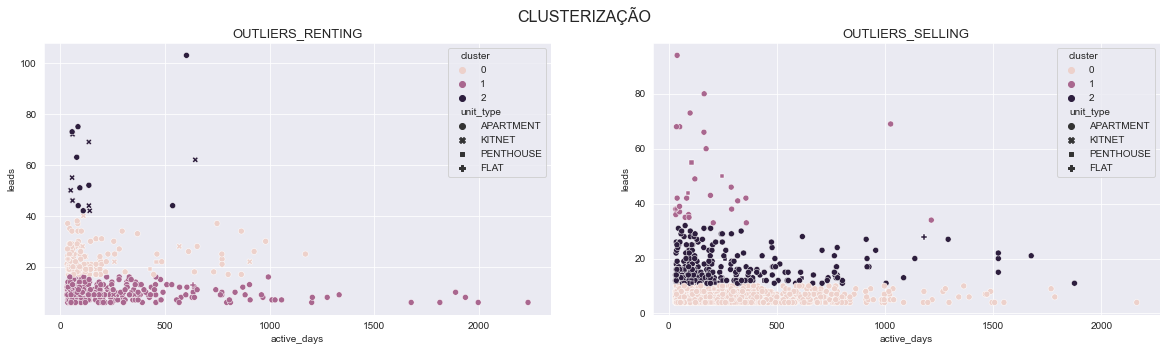

In [85]:
# Cria filtros para análise segmentada de outliers
out_rent = has_lead.query('(listing_type == "ALUGUEL") & (position == "OUTLIER")').reset_index().copy()
out_sell = has_lead.query('(listing_type == "VENDA") & (position == "OUTLIER")').reset_index().copy()
norm_rent = has_lead.query('(listing_type == "ALUGUEL") & (position =="NORMAL")').reset_index().copy()
norm_sell = has_lead.query('(listing_type == "VENDA") & (position == "NORMAL")').reset_index().copy()

# Cria dicionário para armazenar os dataframes filtrados para o cálculo 
dfs = {'OUTLIERS_RENTING': out_rent, "OUTLIERS_SELLING": out_sell, 'NORMAL_RENTING': norm_rent, 'NORMAL_SELLING': norm_sell}

# Configura plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(1,2, figsize = (20, 5))
fig.suptitle('CLUSTERIZAÇÃO', fontsize=16)

# Calcula outliers e plota os dados
for name in dfs.keys():
    df = dfs[name]
    kmeans = KMeans(n_clusters=3)
    df_transf = df[['leads']]
    kmeans.fit(df_transf)
    df['cluster'] = kmeans.labels_
    indice = list(dfs.keys()).index(name)
    if 'OUTLIER' in str(name):
        sns.scatterplot(y='leads', x='active_days',style='unit_type', hue='cluster', data = df, ax=axs[indice])
        axs[indice].set_title(f'{name}', fontsize=13)
        axs[indice].grid(True, 'minor');

### TAKEAWAYS
> Em ambos os gráfcos observa-se que os anúncios do **_cluster 2_**, que possuem melhor desempenho, têm proporcionalmente mais anúncios com **_menor tempo ativo_** nos portais.
> Outro ponto de destaque é que para anúncios de **_ALUGUEL_**, existe uma proporção grande de **_KITNETS_** nos clusters de **_melhor performance_**.</br>
> Este comportamento não é observado em anúncios de vendas, que são majoritariamente referentes a **_APARTAMENTOS_**.</BR>
É Possível que isto se deva a uma **_oferta menor em relação à demanda_**, quanto comparado com os apartamentos.

**_Durante a clusterização foi encontrado um registro com um preço incomum.</br>
Este será excluído para que não comprometa a análise do todo_.**

In [86]:
# Imprime valor discrepante encontrado
display("PREÇO DISCREPANTE:" ,out_sell.iloc[708]['price'])
#deleta regitro
out_sell.drop(index=708, inplace=True)

'PREÇO DISCREPANTE:'

45187613

## CARACTERÍSTICAS COMUNS 🏘️
> São muitas as variáveis que podem impactar o desempenho de um anúncio.</br>
Mas uma **_causa raíz_** comum a todas elas é a demanda.</br>
Para entender um pouco melhor esta relação , foram selecionadas as **_principais características de um imóvel_** com o intuito de visualizar se existe algum **_padrão ao longo dos clusters de desempenho_**.</br>
Nos quadros abaixo, as linhas estão **_ordenadas por clusters com menor número de leads para o maior._**

In [87]:
for name in dfs.keys():
    dfs[name] = dfs[name].groupby(['cluster']).agg({
    'leads':['min','mean'],
         'listing_id' :'count',
        'active_days': 'mean',
        'price':'mean',
        'usable_areas':'mean',
        'bedrooms':'mean',
        'suites':'mean',
        'parking_spaces':'mean'
    })
    
    dfs[name]= dfs[name].reset_index()
    dfs[name].columns = [f'{x[0]}_{x[1]}' for x in dfs[name].columns]
    dfs[name] = dfs[name].sort_values('leads_min').copy()
    dfs[name] = dfs[name].drop(columns=['cluster_'])
    
    
display("NORMAL_RENTING", dfs["NORMAL_RENTING"].style.background_gradient(cmap='PuBu',axis=0)
    ,"OUTLIERS_RENTING", dfs["OUTLIERS_RENTING"].style.background_gradient(cmap='PuBu', axis=0)
    , "NORMAL_SELLING", dfs["NORMAL_SELLING"].style.background_gradient(cmap='PuBu',axis=0)
    , "OUTLIERS_SELLING", dfs["OUTLIERS_SELLING"].style.background_gradient(cmap='PuBu', axis=0)    
    )

'NORMAL_RENTING'

,leads_min,leads_mean,listing_id_count,active_days_mean,price_mean,usable_areas_mean,bedrooms_mean,suites_mean,parking_spaces_mean
0,1.000000,1.305432,2927,251.175265,1414.272634,86.902289,2.379228,0.774513,1.484797
2,3.000000,3.355362,802,215.541147,1236.129676,77.700748,2.271820,0.579800,1.341646
1,5.000000,5.990234,512,191.298828,1250.437500,75.279297,2.232422,0.611328,1.359375


'OUTLIERS_RENTING'

,leads_min,leads_mean,listing_id_count,active_days_mean,price_mean,usable_areas_mean,bedrooms_mean,suites_mean,parking_spaces_mean
1,6.000000,10.120548,365,236.043836,1123.104110,69.786301,2.172603,0.490411,1.219178
0,17.000000,23.135338,133,202.278195,1041.436090,68.240602,2.015038,0.436090,1.090226
2,42.000000,58.058824,17,180.764706,851.470588,51.235294,1.588235,0.235294,0.941176


'NORMAL_SELLING'

,leads_min,leads_mean,listing_id_count,active_days_mean,price_mean,usable_areas_mean,bedrooms_mean,suites_mean,parking_spaces_mean
0,1.000000,1.000000,8784,299.184654,405717.447177,91.219604,2.474613,0.919057,1.631034
1,2.000000,2.000000,2631,293.155834,456980.744584,91.685671,2.491448,0.962752,1.643482
2,3.000000,3.000000,1135,275.610573,375281.274890,87.600881,2.460793,0.877533,1.614978


'OUTLIERS_SELLING'

,leads_min,leads_mean,listing_id_count,active_days_mean,price_mean,usable_areas_mean,bedrooms_mean,suites_mean,parking_spaces_mean
0,4.000000,5.694240,1632,255.660539,369271.071691,86.906250,2.441176,0.900123,1.593750
2,11.000000,16.116564,326,254.067485,359734.987730,83.895706,2.441718,0.923313,1.592025
1,33.000000,48.800000,30,204.266667,265781.466667,80.666667,2.200000,0.766667,1.466667


### TAKEAWAYS
> Pelo contraste de cores, observa-se que há um comportamento relativamente uniforme uniforme entre as segmentações. </br>
Uma característica é invariável para todas as tabelas, a relação de oferta e demanda.</br> 
**_Anúncios com mais leads são também os de menor oferta_**.

#### ALUGUEL
> **_Os anúncios com menor quantidade de leads tendem a ser maiores, mais caros e mais antigos._**</br>
O preço médio de anúncios com apenas **_1 lead é de R\\$1414,00_**, enquanto para os anúncios do último cluster com média de **_42 leads, custam R\\$851,00._**</br>
Tal característica reflete a grande proporção de kitnets presentes nos anúncios de melhor desempenho, observados durante a clusetrização.

#### VENDA
> Para venda, o padrão é ligeiramente diferente. **_Os anúncios mais recentes continuam gerando, em média, mais leads._** </br>
Porém, é o **_cluster intermediário que concentra os apartamentos maiores._**</br>
Uma **_hipótese_** par explicar este padrão é :</br>
**_Imóveis menores tem uma oferta menor_** e por isto continuarão sendo os mais procurados.</br>
A compra de um imóvel é uma **_aquisição de longo prazo_**, com uma expectativa de troca distante. Por isso as pessoas prefeririam comprar imóveis maiores em relação a quando alugam.

# CONCLUSÃO 💡


### RESPOSTA
>**_Anúncios com endereço incompleto possuem um melhor desempenho?_**</br>

Como observado durante a análise, as distribuições de quantidade de leads por anúncio com ou sem exibição do endereço completo são bastante similares.</br>
Contudo, alguns anúncios com endereço completo receberam quantidades de leads muito maiores do que a média de anúncios com endereços incompletos.</br>
Visto que o volume de anúncios que receberam algum lead e exibem todo o endereço é **_4 vezes menor_** do que os que não o exibem, a ocorrência destes outliers torna a média de leads/anúncio do primeiro maior.</br>
Além disso, a taxa de anúncios que recebem ao menos um lead é maior nos casos de endereço completo. </br>
Dessa forma, o grupo de anúncios com endereço completo têm **_proporcionalmente mais anúncios que recebem leads_** e também **_mais leads recebidos/anúncio._**

><u>**_Portanto, pode-se rejeitar a hipótese de que anúncios incompletos possuem um desempenho melhor do que os completos_**</u>

Ao expandir a análise para outras características, foram encontradas outras variáveis que parecem ser mais determinantes no desempenho de um anúncio. São elas:
- **_Segmento_** _(compra ou venda)_
- **_Portal_** _(tráfego)_
- **_Oferta_** _(quantidade de imóveis similares anunciados)_
- **_Metragem_** _(~ banheiros, quartos, suites e estcionamento)_   
- **_Tempo_** _(data criação do anúncio)_
- **_Preço_**

### RESSALVAS
Para ser possível responder se a exibição do endereço completo ou não têm impacto na geração de leads, foi preciso realizar alguns tratamentos na base de dados.</br>
Um deles foi a validação da **_convergência do CEP e Rua_** informados para o mesmo local. Já que informações divergentes poderiam gerar dúvidas e consequentemente mais leads. Então, para isolar o efeito da exibição do endereço, excluiu-se, cerca de **_1700 anúncios_** com informações conflitantes da análise.</br> 
Para tanto, utilizou-se de uma **API não oficial**, que pode conter informações inacuradas ou incompletas. Neste sentido, o preenchimento incorreto de campos, como a inserção de número de rua ou ano de construção do imóvel no campo de **_CEP_**, pode ter influência nos resultados obtidos.</br>
Outro tratamento realizado foi a classificação de anúncios nos segmentos de **_"Aluguel"_** _(900 - 1500 reais)_ e  **_"Venda"_** _(120K +)_ , como nem todos os registros tinham seus preços nos intervalos definidos, exlcuiu-se **_800 anúncios_** que não puderam ser **_reclassificados com base no preço do m2_**, para que uma definição arbitrária não afetasse a análise</br>
Por fim, em alguns momentos a análise tratou os dados do **_ZAP e VIVAREAL_** da mesma forma. Porém, cada portal tem suas particularidades, além do tráfego e da falta de registros de endereço completo nos daos referentes ao **_ZAP_**, há também uma diferença sutil na forma como os leads são gerados. Na plataforma do **_ZAP_** existem apenas **_2 botões_** para solicitar contato, enquanto no **_VIVAREAL há 4 botões_**, sendo que um deles é o **_"VER TELEFONE"_**.</br>
Este botão apresenta um **_"teaser"_** do número, o que tendencia o clique. Ao mesmo tempo em que requer menos esforço do usuário para se tornar um lead, já que não é necessário o envio de mensagem.</br>
Estas características colaboram para o **_maior número de leads do VIVAREAL_** e podem ter enviesado a análise de alguma forma.


### PRÓXIMOS PASSOS
Alguns próximos passos para complementar o estudo seriam:

- **_Averiguar viabilidade de se obter a segmentação dos leads por botão utilizado para revisão dos resultados obtidos_**
- **_Análise da relação de anunciantes, ano de construção, bairro e cidade com o desempenho de anúncios_**
- **_Estudo do ganho de informação potencial pela implementação de validação da convergência do endereço ao publicar um anúncio_** _(e possíveis perdas para o negócio )_
- **_Criação de categorias de imóveis com base em suas características_**  _(ex: m2, preço, data de construção e região)_
- **_Criação de "Listing Score"_**  _(tempo de anúncio, recorrência e desemepenho do anunciante, quantidade e qualidade das imagens)_